In [1]:
#Here, we will mess around with heat maps for the respective categories

#imprt the necessary calculations for everything we will use
from datetime import datetime, timedelta
import time
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from netCDF4 import Dataset, num2date, date2num
import numpy as np
from scipy.ndimage import gaussian_filter
from shapely.geometry.polygon import LinearRing
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xlrd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import linregress

################################################################################
from IPython import embed
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
import cartopy
from shapely.prepared import prep
import seaborn as sns
import collections

In [17]:
#blue marble pathway
os.environ["CARTOPY_USER_BACKGROUNDS"] = '/Users/cjmasiel/Desktop/Cartopy/BG/'

In [3]:
#this is the function that creates the map background of the North Atlantic Domain
def create_map_background():
    dataproj = ccrs.PlateCarree()
    fig=plt.figure(figsize=(25, 25))
    ax=plt.subplot(111, projection=dataproj)
    ax.set_extent([-20, -105, 5, 50], ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    
    gl = ax.gridlines(color='gray', alpha=0.5, draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 16}
    gl.ylabel_style = {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([0, -10, -20, -30, -40, -50, -60, -70, -80, -90, -100, -110])
    gl.ylocator = mticker.FixedLocator([0, 10, 20, 30, 40, 50])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ###############################################################################################
    ax.background_img(name='BM', resolution='high')
    ###############################################################################################
    plt.scatter(-180,-40,alpha = 1.0, color = '#5ebaff', label = 'Tropical Depression')
    plt.scatter(-180,-40,alpha = 1.0, color='#00faf4', label = 'Tropical Storm')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffffcc', label = 'Category 1')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffe775', label = 'Category 2')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffc140', label = 'Category 3')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff8f20', label = 'Category 4')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff6060', label = 'Category 5')
    plt.legend(loc = 'upper left', fontsize = '20')
    return fig, ax

In [7]:
######################################
#Here, specify years of interest you are interested in looking at
lower_bound = 1850
upper_bound = 2022

In [9]:
#Now that we have the storms we are interested in looking, we will loop through the same list as before\n",
#However, this time we will have a bunch of logical

with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
    lines_to_read = 0
    code = None
    storm_data = collections.defaultdict(list)
   
    for line in ds:
        values = line.split(",")
       
        if lines_to_read == 0:
            lines_to_read = int(values[2])
            code = str(values[0])
        else:
            latitude = float(values[4][:-1])
            longitude = -1 * float(values[5][:-1])
            vmax = float(values[6])
            nature = str(values[3])
            time = str(values[1])
            pressure = str(values[7])
            year = int(values[0][0:4])
            month = int(values[0][4:6])
            date_str = values[0].strip()
           
            #if (time in (' 0000', ' 0600', ' 1200', ' 1800') and 
            if (nature in (' TD', ' TS', ' HU') and 
                lower_bound <= year <= upper_bound and 
                vmax >= 140):
                
                storm_data[code].append({
                    "latitude": latitude,
                    "longitude": longitude,
                    "vmax": vmax,
                    "time": time,
                    "pressure": pressure,
                    "nature": nature,
                    "month": month,
                    "date_str": date_str
                })
           
            lines_to_read -= 1

#Print the first elements of storm data for a valid key
print("First elements of storm data", print("First elements of storm data", next(iter(storm_data.values()))))

First elements of storm data [{'latitude': 21.3, 'longitude': -84.7, 'vmax': 145.0, 'time': ' 1200', 'pressure': ' -999', 'nature': ' HU', 'month': 10, 'date_str': '19241019'}, {'latitude': 22.4, 'longitude': -84.4, 'vmax': 145.0, 'time': ' 1800', 'pressure': '  910', 'nature': ' HU', 'month': 10, 'date_str': '19241019'}]
First elements of storm data None


In [11]:
#Initialize lists for storing results
dates_MH = []
Codes = []

# Process storm data
for code, data in storm_data.items():
    if data:  # Ensure there is data for the storm
        Codes.append(code)
        dates_MH.extend([entry["date_str"] for entry in data])

In [13]:
def plotstorm(x):
    Lat = []
    Long = []
    LatStorm = []
    LongStorm = []
    LatStorm1 = []
    LongStorm1 = []
    Lat1 = []
    Long1 = []
    Lat2 = []
    Long2 = []
    Lat3 = []
    Long3 = []
    Lat4 = []
    Long4 = []
    Lat5 = []
    Long5 = []
    LatSS = []
    LongSS = []
    LatEX = []
    LongEX = []

    #Start looping through the text file
    with open('/Users/cjmasiel/desktop/HURDAT2.txt', 'r') as ds:
        lines_to_read = 0
        for line in ds:
            values = line.split(",")
            if lines_to_read == 0:
                lines_to_read = int(values[2])
                code = str(values[0])
            else:
                latitude  = float(values[4][:-1])
                longitude = -1 * float(values[5][:-1])
                vmax      = float(values[6])
                nature    = str(values[3])
                time      = str(values[1])
                if code == x: #and time in (' 0000', ' 0600', ' 1200', ' 1800'):
                    LatStorm1.append(latitude)
                    LongStorm1.append(longitude)
                    if vmax < 34 and nature in (' TD', ' TS', ' HU'):
                        Lat.append(latitude)
                        Long.append(longitude)
                    if 34 <= vmax < 63 and nature in (' TD', ' TS', ' HU'):
                        LatStorm.append(latitude)
                        LongStorm.append(longitude)
                    if 63 < vmax <= 83 and nature in (' TD', ' TS', ' HU'):
                        Lat1.append(latitude)
                        Long1.append(longitude)
                    if 83 < vmax <= 95 and nature in (' TD', ' TS', ' HU'):
                        Lat2.append(latitude)
                        Long2.append(longitude)
                    if 95 < vmax <= 112 and nature in (' TD', ' TS', ' HU'):
                        Lat3.append(latitude)
                        Long3.append(longitude)
                    if 112 < vmax <= 136 and nature in (' TD', ' TS', ' HU'):
                        Lat4.append(latitude)
                        Long4.append(longitude)
                    if vmax > 136 and nature in (' TD', ' TS', ' HU'):
                        Lat5.append(latitude)
                        Long5.append(longitude)
                    if nature in (' SS'):
                        LatSS.append(latitude)
                        LongSS.append(longitude)
                    if nature in (' EX',' LO',' WV',' SD',' DB'):
                        LatEX.append(latitude)
                        LongEX.append(longitude)  
                #After going through all these logical loops, now we read back one
                lines_to_read -=1
    
    #Below is the plotting code \n",
    plt.plot(LongStorm1, LatStorm1, alpha = 1.0, color='grey', linewidth=1,zorder=1)
    plt.scatter(Long, Lat, color = '#5ebaff',s=50, label = 'Tropical Depression',zorder=2)
    plt.scatter(LongStorm,LatStorm, color='#00faf4',s=50, label = 'Tropical Storm',zorder=3)
    plt.scatter(Long1,Lat1,alpha = 1.0,s=50, color='#ffffcc', label = 'Category 1',zorder=4)
    plt.scatter(Long2,Lat2,alpha = 1.0, s=50,color='#ffe775', label = 'Category 2',zorder=5)
    plt.scatter(Long3,Lat3,alpha = 1.0,s=50, color='#ffc140', label = 'Category 3',zorder=6)
    plt.scatter(Long4,Lat4,alpha = 1.0,s=50, color='#ff8f20', label = 'Category 4',zorder=7)
    plt.scatter(Long5,Lat5,alpha = 1.0,s=50, color='#ff6060', label = 'Category 5',zorder=8)
    plt.scatter(LongEX,LatEX,alpha = 1.0,s=50, color='#5ebaff', marker  = 'v', label = 'Extra-Tropical',zorder=9)
    plt.scatter(LongSS,LatSS,alpha = 1.0,s=50, color='#00faf4', marker = 'v', label = 'Sub-Tropical Storm',zorder=10)
    
    plt.title('Category 5 Hurricanes, (1851-2022)', loc = 'left',fontsize = 24)
    plt.title('Product by: Cameron Masiello', loc = 'right', fontsize = 24)

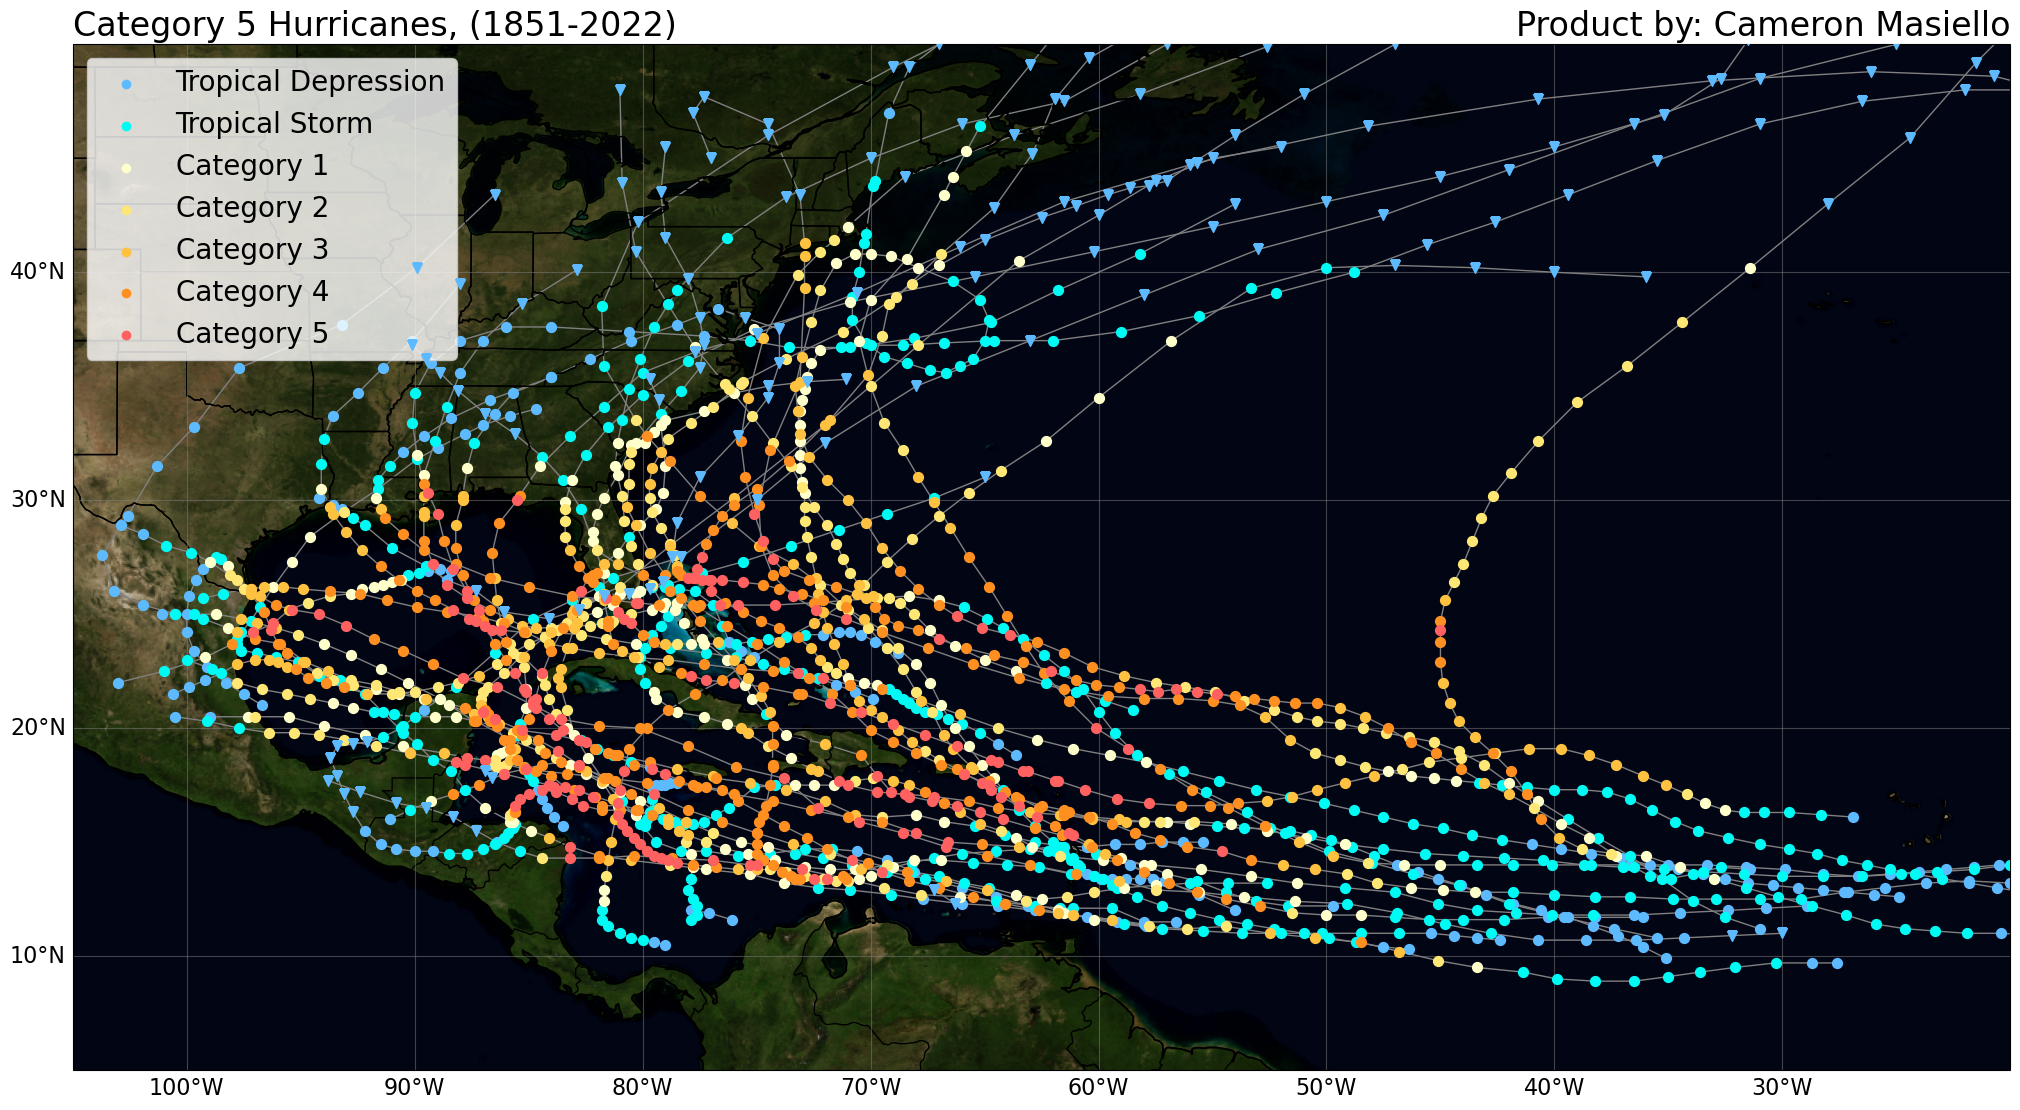

In [19]:
#Eastern MDR Major Hurricanes 

fig, ax = create_map_background()

for i in range(len(Codes)):
    plotstorm(Codes[i])

#Save the figure
save_path = '/Users/cjmasiel/desktop/Hurricanes.png'
plt.savefig(save_path, bbox_inches='tight')
    
plt.show()
plt.close()

min = 197
max = 312


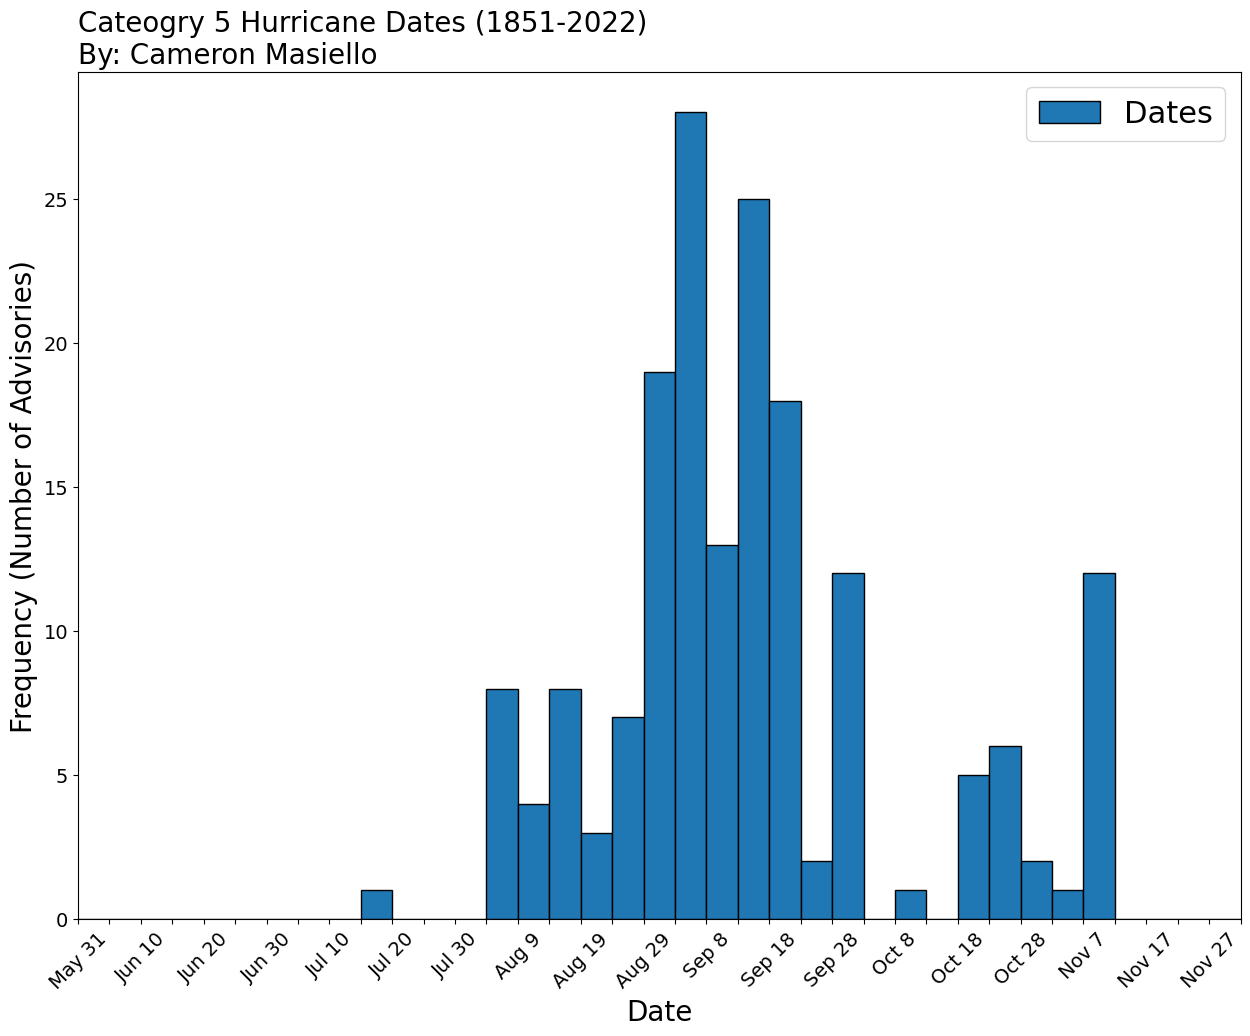

In [21]:
import collections
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Initialize lists for storing results
dates_MH = []
Codes = []

# Process storm data
for code, data in storm_data.items():
    if data:  # Ensure there is data for the storm
        Codes.append(code)
        dates_MH.extend([entry["date_str"] for entry in data])

# Convert date strings to datetime objects
dates_MH = [datetime.strptime(date_str, '%Y%m%d') for date_str in dates_MH]

# Convert LAND_FALL_DATES to days since New Year
def convert_dates_to_days_since_new_year(dates):
    days_since_new_year = []
    for date in dates:
        new_year = datetime(date.year, 1, 1)
        delta = date - new_year
        days_since_new_year.append(delta.days)
    return days_since_new_year

# Function to map days since New Year to month-day labels
def days_to_months_and_days():
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days_to_month_day = {}
    day_of_year = 0
   
    for i, days in enumerate(month_days):
        for day in range(1, days + 1):
            days_to_month_day[day_of_year] = f"{month_labels[i]} {day}"
            day_of_year += 1
   
    return days_to_month_day

days_to_month_day = days_to_months_and_days()

# Convert LAND_FALL_DATES to days since New Year
landfall_days_since_new_year = convert_dates_to_days_since_new_year(dates_MH)

# Now, input the data we will use for plotting
time_is_a_construct = []

for item in Codes:
    storm_dates = [entry["date_str"] for entry in storm_data[item]]
    storm_dates = [datetime.strptime(date_str, '%Y%m%d') for date_str in storm_dates]
    storm_days_since_new_year = convert_dates_to_days_since_new_year(storm_dates)
    time_is_a_construct.extend(storm_days_since_new_year)

print("min =", min(time_is_a_construct))
print("max =", max(time_is_a_construct))

# Increase the size of the plot
plt.figure(figsize=(15, 11))

# Create histogram for date of NC landfall
plt.hist(landfall_days_since_new_year, bins=range(0, 365, 5), edgecolor='black',
         alpha=1, label='Dates')

plt.xlabel('Date', fontsize=20)
plt.ylabel('Frequency (Number of Advisories)', fontsize=20)
plt.title('Cateogry 5 Hurricane Dates (1851-2022)\nBy: Cameron Masiello', fontsize=20, loc='left')

# Adjust x-axis labels to show months and days
bin_edges = range(0, 365, 5)
bin_labels = [days_to_month_day.get(day, '') for day in bin_edges]

# Skip every 4th label
skipped_bin_labels = [label if i % 2 == 0 else '' for i, label in enumerate(bin_labels)]

plt.xticks(bin_edges, skipped_bin_labels, rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(150, 335)

# Add a legend
plt.legend(fontsize=22)

save_path = '/Users/cjmasiel/desktop/Hurricanes_dates.png'
plt.savefig(save_path, bbox_inches='tight')

plt.show()

In [23]:
#Next, I want to look at the location of cat 5 points
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Define the base color as '#00faf4'
base_color = 'red'

#Define the number of steps in the color scale
num_steps = 5

#Create a linearly spaced array of alpha values from 0 to 1\n",
alphas = np.linspace(0, 1, num_steps)

#Create a list of colors with varying alpha values\n",
colors = [mcolors.to_rgba(base_color, alpha=a) for a in alphas]

#Create a color map using the list of colors
cmap_new = mcolors.ListedColormap(colors)

def RIdinsity(x,y,z):
    plt.title('Center Location of Category 5s in the NATL (1851-2022)', {"fontsize": 32}, loc = 'left')
    plt.title(f'Product By: Cameron Masiello \n NUMBER OF CASES ={z}', {"fontsize": 24}, loc = 'Right')
    plot = plt.hist2d(x, y, bins=[list(range(-110, -10)), list(range(5, 50))], cmap=cmap_new)
    plt.clim(0,5)
    cbar = plt.colorbar(orientation = 'horizontal', pad = .05, shrink = 1, aspect = 50, extend = 'both')
    cbar.ax.set_xlabel('1 x 1 Degree Density', fontsize = 20)

In [25]:
#this is the function that creates the map background of the North Atlantic Domain
def create_map_background():
    dataproj = ccrs.PlateCarree()
    fig=plt.figure(figsize=(25, 25))
    ax=plt.subplot(111, projection=dataproj)
    ax.set_extent([-20, -105, 5, 50], ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    
    gl = ax.gridlines(color='gray', alpha=0.5, draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 16}
    gl.ylabel_style = {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([0, -10, -20, -30, -40, -50, -60, -70, -80, -90, -100, -110])
    gl.ylocator = mticker.FixedLocator([0, 10, 20, 30, 40, 50])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ###############################################################################################
    ax.background_img(name='BM', resolution='high')
    ###############################################################################################
    plt.scatter(-180,-40,alpha = 1.0, color = '#5ebaff', label = 'Tropical Depression')
    plt.scatter(-180,-40,alpha = 1.0, color='#00faf4', label = 'Tropical Storm')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffffcc', label = 'Category 1')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffe775', label = 'Category 2')
    plt.scatter(-180,-40,alpha = 1.0, color='#ffc140', label = 'Category 3')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff8f20', label = 'Category 4')
    plt.scatter(-180,-40,alpha = 1.0, color='#ff6060', label = 'Category 5')
    plt.legend(loc = 'upper left', fontsize = '20')
    return fig, ax

In [27]:
#Initialize lists for storing results
lat_5 = []
lon_5 = []

#Process storm data
for code, data in storm_data.items():
    if data:  # Ensure there is data for the storm
        lat_5.extend([entry["latitude"] for entry in data])
        lon_5.extend([entry["longitude"] for entry in data])

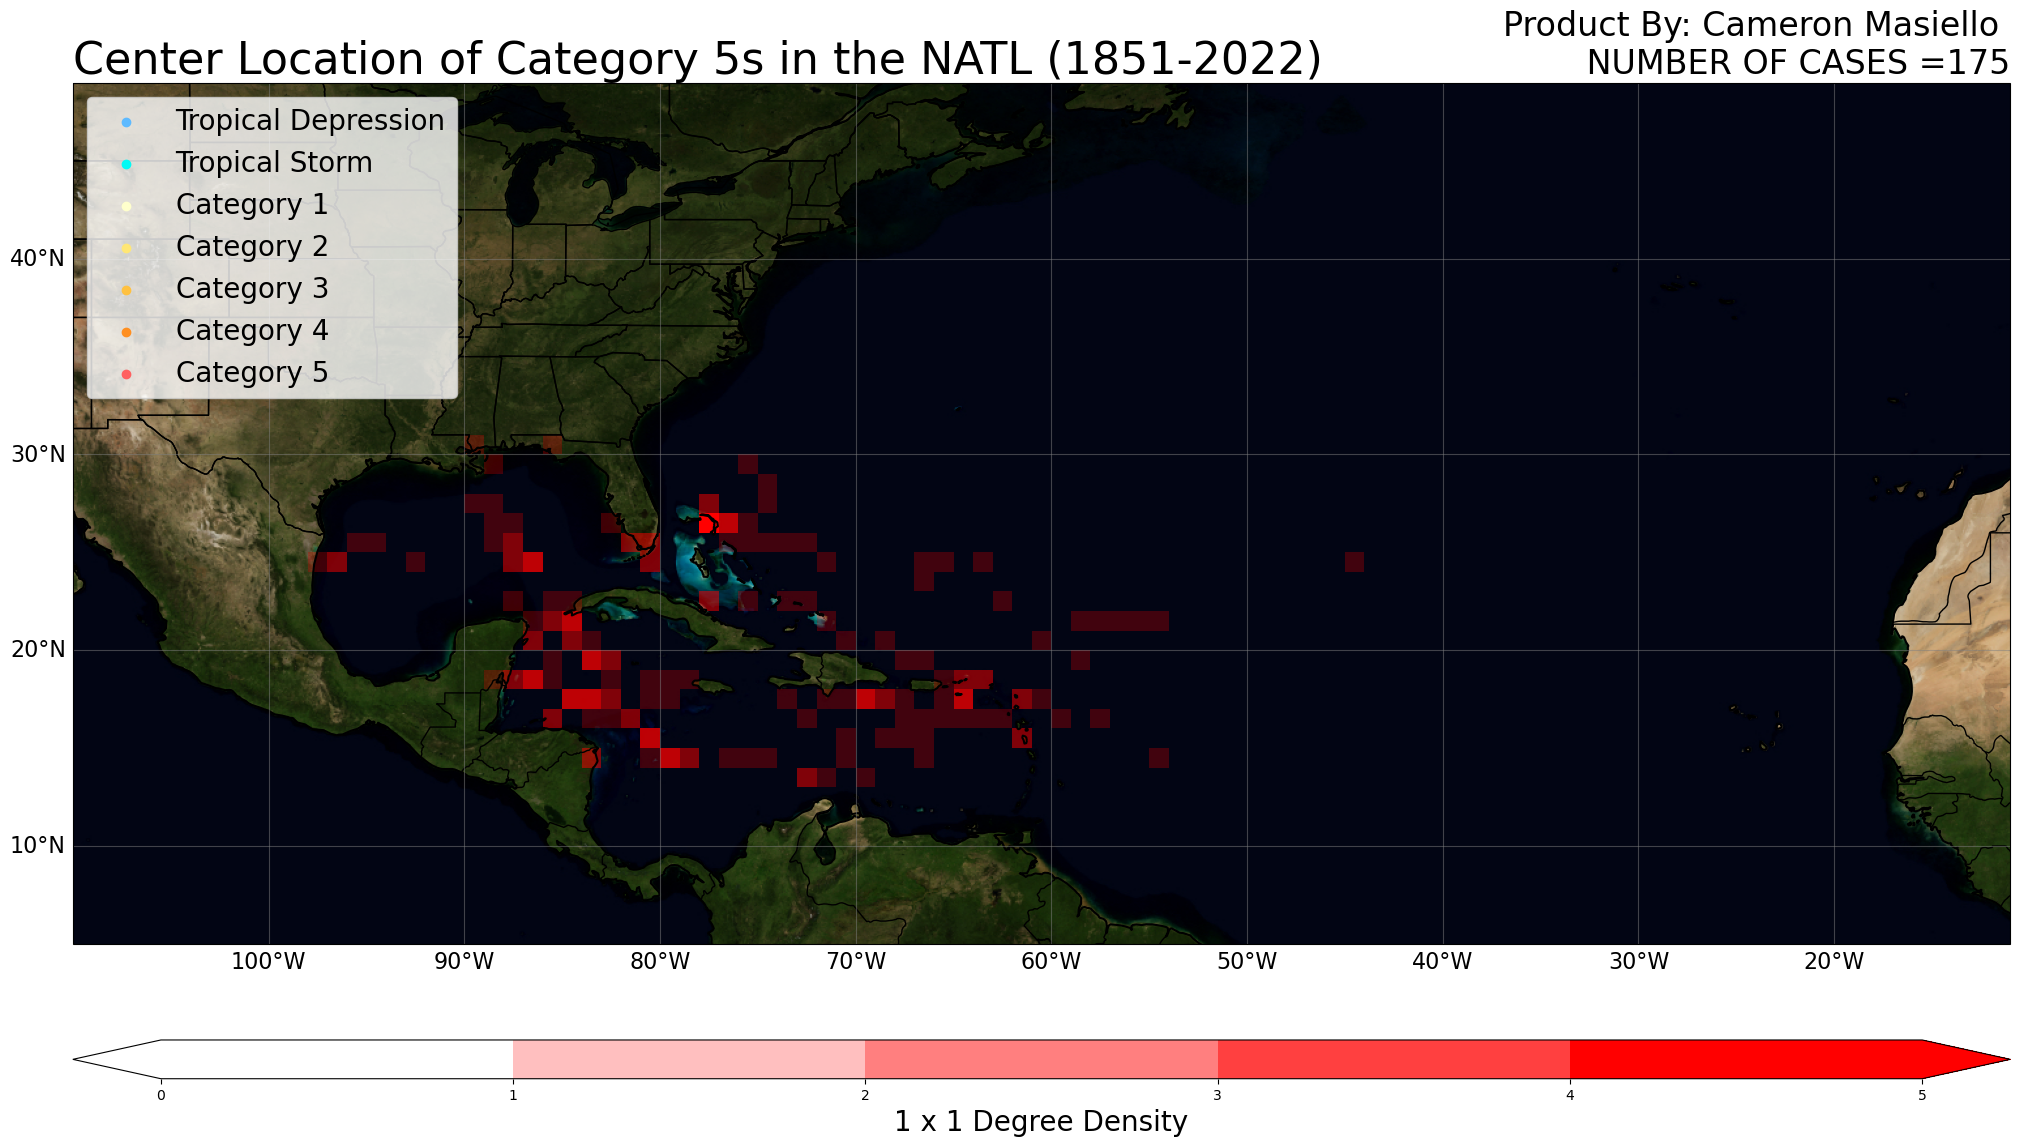

In [29]:
#now, lets plot the whole 1980-2022 Atlantic Distribution

fig, ax = create_map_background()

RIdinsity(lon_5,lat_5,len(lat_5))

In [30]:
import requests
import collections
from io import StringIO

# Fetch data from the URL
url = 'https://ftp.nhc.noaa.gov/atcf/btk/bal022024.dat'
response = requests.get(url)
data = response.text

# Process the data as if it's a file
ds = StringIO(data)
storm_data_ATCF_BT = collections.defaultdict(list)

# Set your year bounds and other parameters
lower_bound = 2020
upper_bound = 2024

for line in ds:
    if not line.startswith("AL"):  # Skip header lines
        continue
    
    values = line.split(",")
    
    code = values[1].strip()
    datetime_str = values[2].strip()
    year = int(datetime_str[:4])
    
    latitude = float(values[6][:-1]) / 10.0  # Adjust latitude format
    longitude = -float(values[7][:-1]) / 10.0  # Adjust longitude format
    vmax = float(values[8])
    nature = values[10].strip()
    pressure = values[9].strip()
    month = int(datetime_str[4:6])
    date_str = datetime_str.strip()

    if (nature in ('TD', 'TS', 'HU')):
        storm_data_ATCF_BT[code].append({
            "latitude": latitude,
            "longitude": longitude,
            "vmax": vmax,
            "datetime": datetime_str,
            "pressure": pressure,
            "nature": nature,
            "month": month,
            "date_str": date_str
        })

# Print the first elements of storm data for a valid key
if storm_data:
    first_key = next(iter(storm_data_ATCF_BT))
    print("First elements of storm data for", first_key, storm_data_ATCF_BT[first_key])
else:
    print("No data found matching the criteria.")

First elements of storm data for 02 [{'latitude': 9.0, 'longitude': -41.0, 'vmax': 30.0, 'datetime': '2024062818', 'pressure': '1007', 'nature': 'TD', 'month': 6, 'date_str': '2024062818'}, {'latitude': 9.2, 'longitude': -42.7, 'vmax': 35.0, 'datetime': '2024062900', 'pressure': '1006', 'nature': 'TS', 'month': 6, 'date_str': '2024062900'}, {'latitude': 9.7, 'longitude': -44.6, 'vmax': 40.0, 'datetime': '2024062906', 'pressure': '1003', 'nature': 'TS', 'month': 6, 'date_str': '2024062906'}, {'latitude': 9.8, 'longitude': -46.9, 'vmax': 55.0, 'datetime': '2024062912', 'pressure': '998', 'nature': 'TS', 'month': 6, 'date_str': '2024062912'}, {'latitude': 9.8, 'longitude': -46.9, 'vmax': 55.0, 'datetime': '2024062912', 'pressure': '998', 'nature': 'TS', 'month': 6, 'date_str': '2024062912'}, {'latitude': 10.0, 'longitude': -48.5, 'vmax': 60.0, 'datetime': '2024062918', 'pressure': '995', 'nature': 'TS', 'month': 6, 'date_str': '2024062918'}, {'latitude': 10.0, 'longitude': -48.5, 'vmax': 

In [33]:
def plotstorm_Beryl():
    Lat = []
    Long = []
    LatStorm = []
    LongStorm = []
    LatStorm1 = []
    LongStorm1 = []
    Lat1 = []
    Long1 = []
    Lat2 = []
    Long2 = []
    Lat3 = []
    Long3 = []
    Lat4 = []
    Long4 = []
    Lat5 = []
    Long5 = []
    LatSS = []
    LongSS = []
    LatEX = []
    LongEX = []

    #Process storm data
    for code, data in storm_data_ATCF_BT.items():
        if data:  # Ensure there is data for the storm
            latitude  = [entry["latitude"] for entry in data]
            longitude = [entry["longitude"] for entry in data]
            vmax      = [entry["vmax"] for entry in data]
            nature    = [entry["nature"] for entry in data]
            time      = [entry["date_str"] for entry in data]
    ###################################################################################################
            for i in range(len(vmax)):
                LatStorm1.append(latitude[i])
                LongStorm1.append(longitude[i])
                if vmax[i] < 34 and nature[i] in ('TD', 'TS', 'HU'):
                    Lat.append(latitude[i])
                    Long.append(longitude[i])
                if 34 <= vmax[i] < 63 and nature[i] in ('TD', 'TS', 'HU'):
                    LatStorm.append(latitude[i])
                    LongStorm.append(longitude[i])
                if 63 < vmax[i] <= 83 and nature[i] in ('TD', 'TS', 'HU'):
                    Lat1.append(latitude[i])
                    Long1.append(longitude[i])
                if 83 < vmax[i] <= 95 and nature[i] in ('TD', 'TS', 'HU'):
                    Lat2.append(latitude[i])
                    Long2.append(longitude[i])
                if 95 < vmax[i] <= 112 and nature[i] in ('TD', 'TS', 'HU'):
                    Lat3.append(latitude[i])
                    Long3.append(longitude[i])
                if 112 < vmax[i] <= 136 and nature[i] in ('TD', 'TS', 'HU'):
                    Lat4.append(latitude[i])
                    Long4.append(longitude[i])
                if vmax[i] > 136 and nature[i] in ('TD', 'TS', 'HU'):
                    Lat5.append(latitude[i])
                    Long5.append(longitude[i])
                if nature[i] in ('SS'):
                    LatSS.append(latitude[i])
                    LongSS.append(longitude[i])
                if nature[i] in ('EX','LO','WV','SD','DB'):
                    LatEX.append(latitude[i])
                    LongEX.append(longitude[i])  

    
    #Below is the plotting code \n",
    plt.plot(LongStorm1, LatStorm1, alpha = 1.0, color='grey', linewidth=1,zorder=1)
    plt.scatter(Long, Lat, color = '#5ebaff',s=50, label = 'Tropical Depression',zorder=2)
    plt.scatter(LongStorm,LatStorm, color='#00faf4',s=50, label = 'Tropical Storm',zorder=3)
    plt.scatter(Long1,Lat1,alpha = 1.0,s=50, color='#ffffcc', label = 'Category 1',zorder=4)
    plt.scatter(Long2,Lat2,alpha = 1.0, s=50,color='#ffe775', label = 'Category 2',zorder=5)
    plt.scatter(Long3,Lat3,alpha = 1.0,s=50, color='#ffc140', label = 'Category 3',zorder=6)
    plt.scatter(Long4,Lat4,alpha = 1.0,s=50, color='#ff8f20', label = 'Category 4',zorder=7)
    plt.scatter(Long5,Lat5,alpha = 1.0,s=50, color='#ff6060', label = 'Category 5',zorder=8)
    plt.scatter(LongEX,LatEX,alpha = 1.0,s=50, color='#5ebaff', marker  = 'v', label = 'Extra-Tropical',zorder=9)
    plt.scatter(LongSS,LatSS,alpha = 1.0,s=50, color='#00faf4', marker = 'v', label = 'Sub-Tropical Storm',zorder=10)
    
    plt.title(f'Hurricane Beryl, 2024\nCenter Location Density of Category 5s in the NATL (1°x1°, 1851-2022)', loc = 'left',fontsize = 24)
    plt.title('Product by: Cameron Masiello', loc = 'right', fontsize = 24)

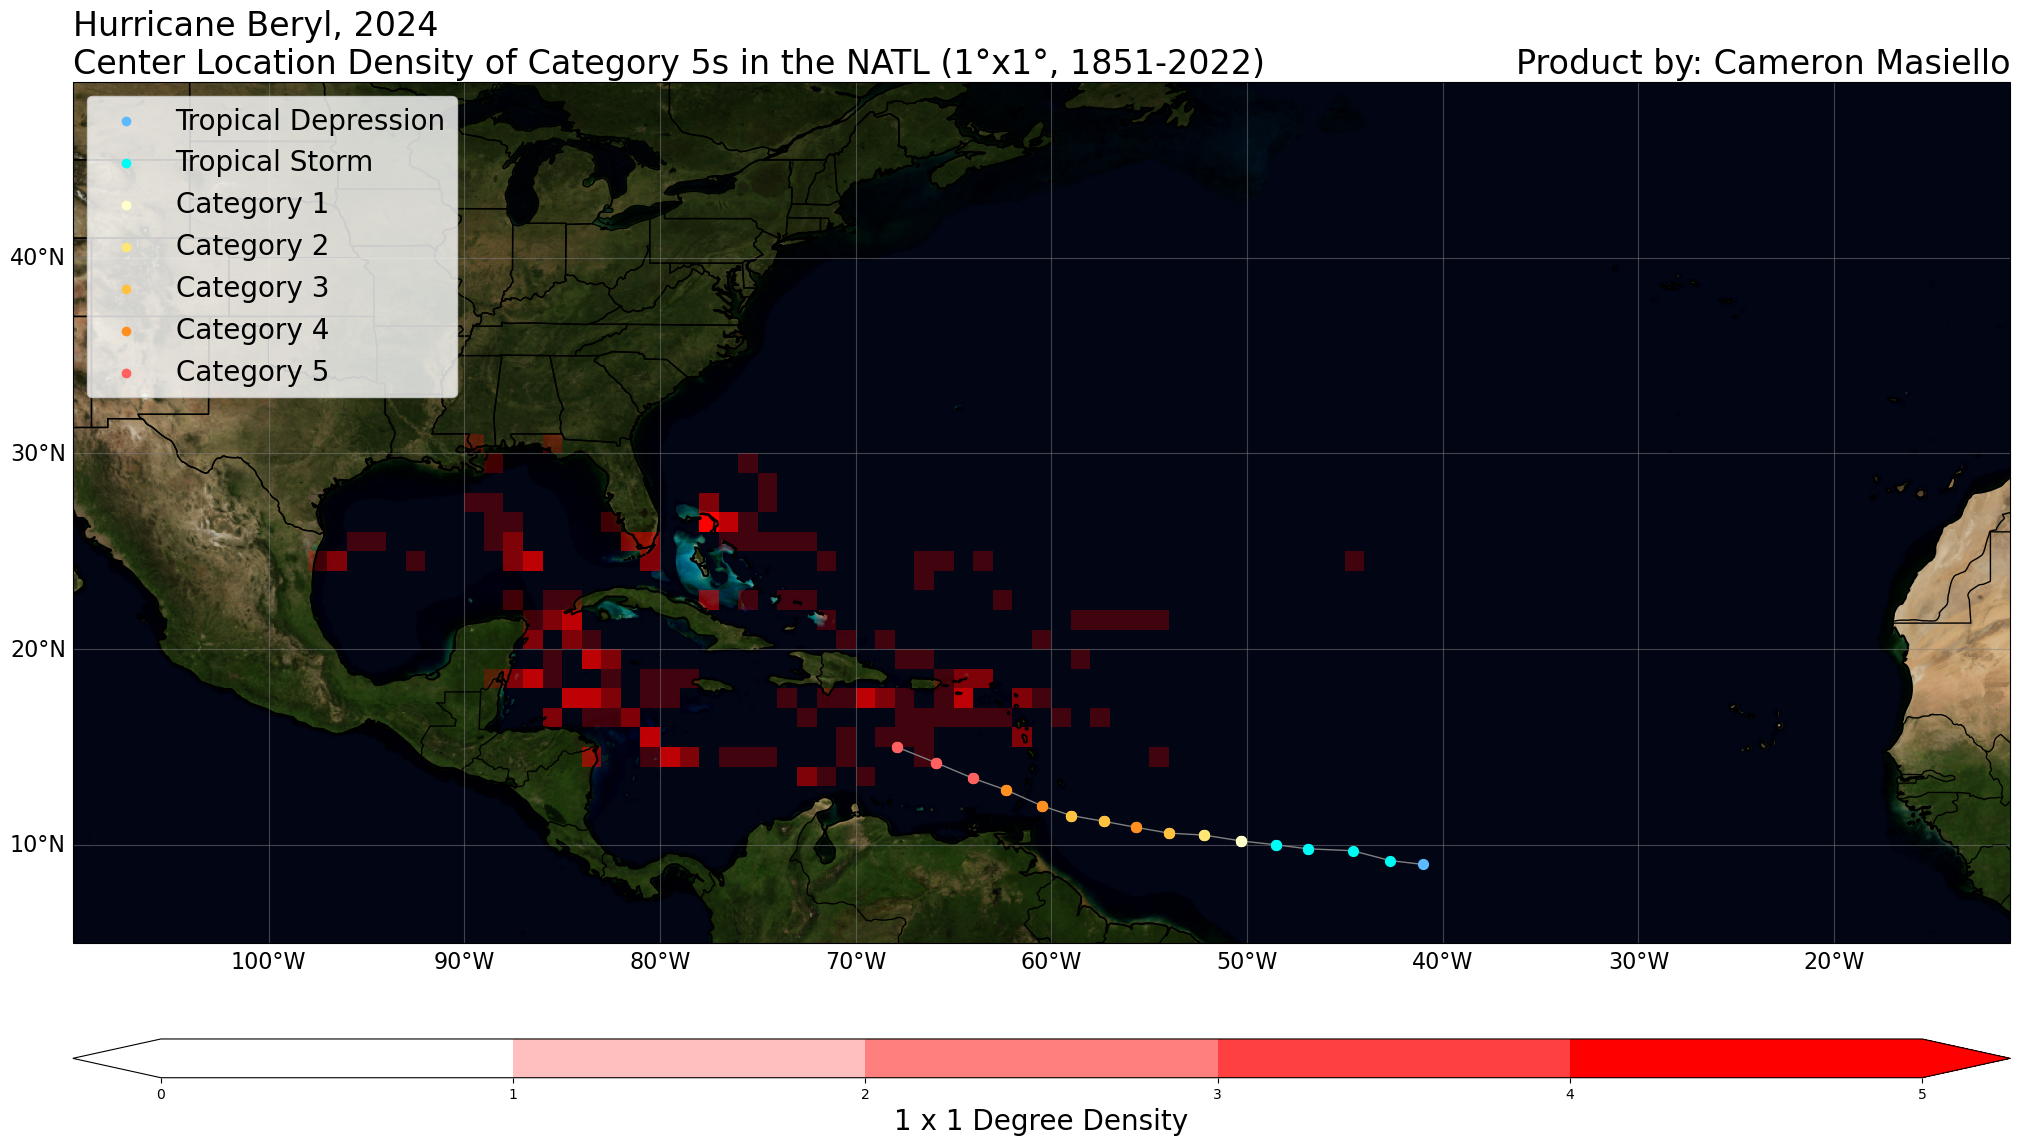

In [35]:
#now, lets plot the whole 1980-2022 Atlantic Distribution

fig, ax = create_map_background()

RIdinsity(lon_5,lat_5,len(lat_5))
plotstorm_Beryl()

plt.show()

In [49]:
import requests
import collections
from io import StringIO

#Fetch data from the URL
url = 'https://ftp.nhc.noaa.gov/atcf/btk/bal022024.dat'
response = requests.get(url)
data = response.text

#Process the data as if it's a file
ds = StringIO(data)
storm_data_ATCF_BT = collections.defaultdict(list)

#Track processed datetime strings for each storm
processed_datetimes = collections.defaultdict(set)

for line in ds:
    if not line.startswith("AL"):  # Skip header lines
        continue
    
    values = line.split(",")
    
    code = values[1].strip()
    datetime_str = values[2].strip()
    year = int(datetime_str[:4])
    
    # Check if this datetime has already been processed for this storm
    if datetime_str in processed_datetimes[code]:
        continue
    
    latitude = float(values[6][:-1]) / 10.0  # Adjust latitude format
    longitude = -float(values[7][:-1]) / 10.0  # Adjust longitude format
    vmax = float(values[8])
    nature = values[10].strip()
    pressure = values[9].strip()
    month = int(datetime_str[4:6])
    date_str = datetime_str.strip()

    if (nature in ('TD', 'TS', 'HU') and vmax >= 140):
        storm_data_ATCF_BT[code].append({
            "latitude": latitude,
            "longitude": longitude,
            "vmax": vmax,
            "datetime": datetime_str,
            "pressure": pressure,
            "nature": nature,
            "month": month,
            "date_str": date_str
        })
        # Mark this datetime as processed
        processed_datetimes[code].add(datetime_str)

# Print the first elements of storm data for a valid key
if storm_data_ATCF_BT:
    first_key = next(iter(storm_data_ATCF_BT))
    print("First elements of storm data for", first_key, storm_data_ATCF_BT[first_key])
else:
    print("No data found matching the criteria.")

First elements of storm data for 02 [{'latitude': 13.4, 'longitude': -64.0, 'vmax': 140.0, 'datetime': '2024070200', 'pressure': '938', 'nature': 'HU', 'month': 7, 'date_str': '2024070200'}, {'latitude': 14.2, 'longitude': -65.9, 'vmax': 145.0, 'datetime': '2024070206', 'pressure': '935', 'nature': 'HU', 'month': 7, 'date_str': '2024070206'}, {'latitude': 15.0, 'longitude': -67.9, 'vmax': 145.0, 'datetime': '2024070212', 'pressure': '934', 'nature': 'HU', 'month': 7, 'date_str': '2024070212'}]


In [51]:
#Initialize lists for storing results
dates_Beryl = []
Codes_Beryl = []

# Process storm data
for code, data in storm_data_ATCF_BT.items():
    if data:  # Ensure there is data for the storm
        Codes_Beryl.append(code)
        dates_Beryl.extend([entry["date_str"] for entry in data])

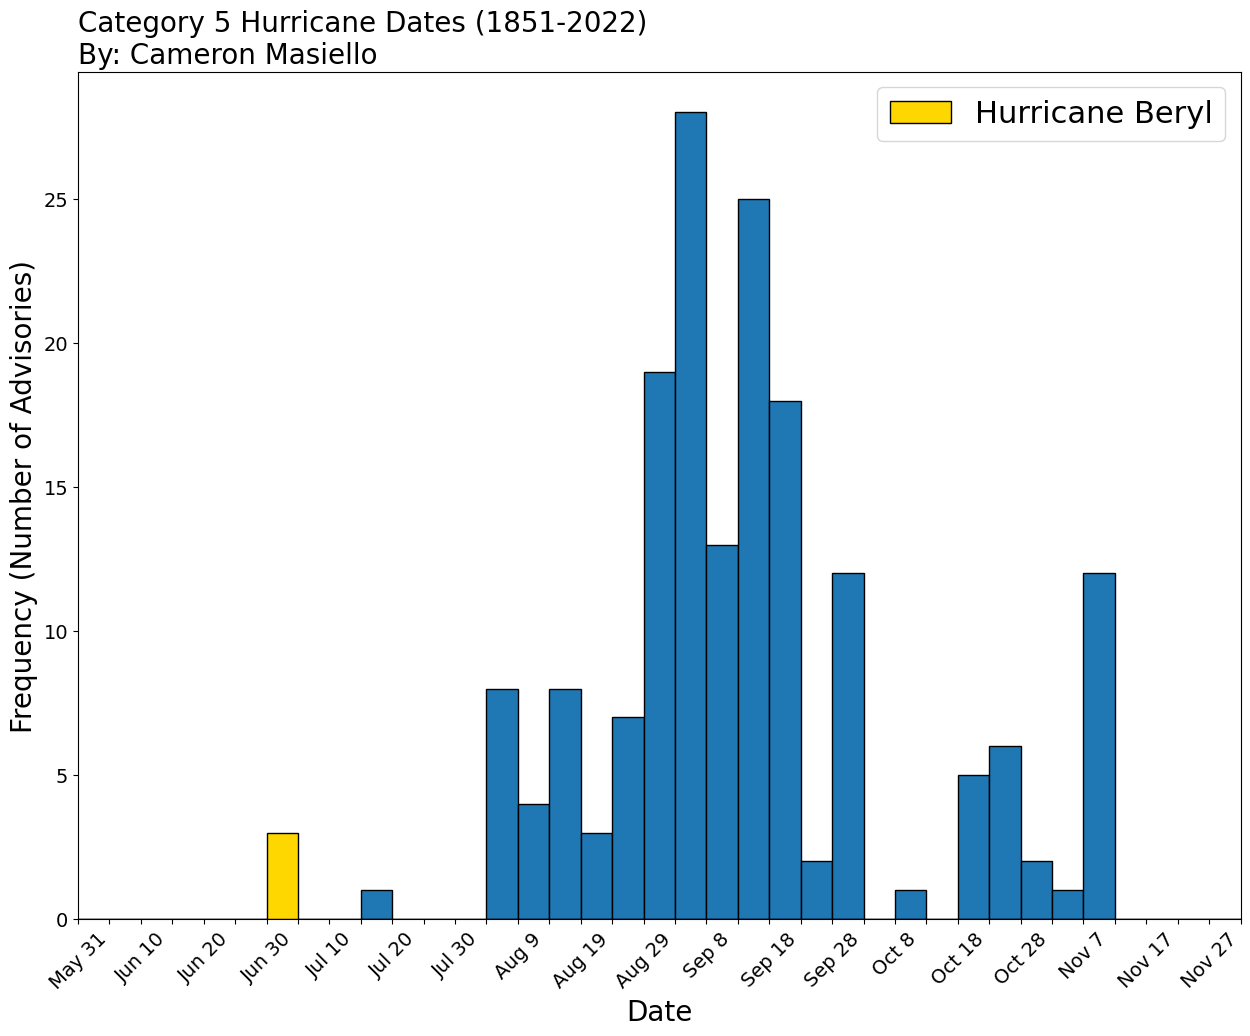

In [53]:
# Initialize lists for storing results
# Initialize lists for storing results
dates_MH = []
Codes = []

# Process storm data
for code, data in storm_data.items():
    if data:  # Ensure there is data for the storm
        Codes.append(code)
        dates_MH.extend([entry["date_str"] for entry in data])

dates_Beryl = []
Codes_Beryl = []

# Process storm data
for code, data in storm_data_ATCF_BT.items():
    if data:  # Ensure there is data for the storm
        Codes_Beryl.append(code)
        dates_Beryl.extend([entry["date_str"] for entry in data])

# Convert date strings to datetime objects
dates_MH = [datetime.strptime(date_str, '%Y%m%d') for date_str in dates_MH]
dates_Beryl = [datetime.strptime(date_str, '%Y%m%d%H%M') for date_str in dates_Beryl]

# Convert LAND_FALL_DATES to days since New Year
def convert_dates_to_days_since_new_year(dates):
    days_since_new_year = []
    for date in dates:
        new_year = datetime(date.year, 1, 1)
        delta = date - new_year
        days_since_new_year.append(delta.days)
    return days_since_new_year

# Function to map days since New Year to month-day labels
def days_to_months_and_days():
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days_to_month_day = {}
    day_of_year = 0

    for i, days in enumerate(month_days):
        for day in range(1, days + 1):
            days_to_month_day[day_of_year] = f"{month_labels[i]} {day}"
            day_of_year += 1

    return days_to_month_day

days_to_month_day = days_to_months_and_days()

# Convert LAND_FALL_DATES to days since New Year
landfall_days_since_new_year = convert_dates_to_days_since_new_year(dates_MH)
landfall_days_since_new_year_Beryl = convert_dates_to_days_since_new_year(dates_Beryl)

# Increase the size of the plot
plt.figure(figsize=(15, 11))

# Create histogram for date of NC landfall
plt.hist(landfall_days_since_new_year, bins=range(0, 365, 5), edgecolor='black', alpha=1)

plt.hist(landfall_days_since_new_year_Beryl, bins=range(0, 365, 5), color='gold', edgecolor='black', alpha=1, label='Hurricane Beryl')

plt.xlabel('Date', fontsize=20)
plt.ylabel('Frequency (Number of Advisories)', fontsize=20)
plt.title('Category 5 Hurricane Dates (1851-2022)\nBy: Cameron Masiello', fontsize=20, loc='left')

# Adjust x-axis labels to show months and days
bin_edges = range(0, 365, 5)
bin_labels = [days_to_month_day.get(day, '') for day in bin_edges]

# Skip every 4th label
skipped_bin_labels = [label if i % 2 == 0 else '' for i, label in enumerate(bin_labels)]

plt.xticks(bin_edges, skipped_bin_labels, rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(150, 335)

# Add a legend
plt.legend(fontsize=22)

save_path = '/Users/cjmasiel/desktop/Hurricanes_dates.png'
plt.savefig(save_path, bbox_inches='tight')

plt.show()